# Исследование рынка заведений общественного питания Москвы

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

**Цель исследования**: исследовать рынок общественного питания в Москве, дать рекомендации о виде заведения, количестве посадочных мест, а также районе расположения, исследовать возможность развития сети.

**Входные данные** представляют собой открытые данные о заведениях общественного питания в Москве.

**Описание данных**:

Таблица `rest_data`:
- `id` — идентификатор объекта;
- `object_name` — название объекта общественного питания;
- `chain` — сетевой ресторан;
- `object_type` — тип объекта общественного питания;
- `address` — адрес;
- `number` — количество посадочных мест.

## Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Откроем файл с данными о заведениях общественного питания Москвы.

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [4]:
for value in rest_data:
    print(rest_data[value].value_counts())

163840    1
207007    1
58806     1
198074    1
150035    1
         ..
29419     1
69506     1
23278     1
185071    1
167934    1
Name: id, Length: 15366, dtype: int64
Столовая               267
Кафе                   236
Шаурма                 234
KFC                    155
Шоколадница            142
                      ... 
Кофейня «Кофе хаус»      1
Кафе «Элла 24»           1
Мрамор                   1
Ресторан «Ерш»           1
Школа 1347               1
Name: object_name, Length: 10393, dtype: int64
нет    12398
да      2968
Name: chain, dtype: int64
кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64
город Москва, Ходынский 

In [5]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


### Обработка пропусков

Посчитаем количество пропущенных значений для каждого столбца.

In [6]:
rest_data.isna().mean()

id             0.0
object_name    0.0
chain          0.0
object_type    0.0
address        0.0
number         0.0
dtype: float64

Пропусков нет.

### Приведение данных к нужным типам

Приведем тип данных столбца `chain` к типу 'bool'.

In [7]:
def chain_to_bool(value):
    if value == 'да':
        return True
    return False

rest_data['chain'] = rest_data['chain'].apply(chain_to_bool)

Проверим.

In [8]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  bool  
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: bool(1), int64(2), object(3)
memory usage: 615.4+ KB


### Обработка дубликатов

Приведем к нижнему регистру столбцы типа 'object', чтобы потом найти явные дубликаты.

In [9]:
rest_data['object_name'] = rest_data['object_name'].str.lower()
rest_data['address'] = rest_data['address'].str.lower()

Явные дубликаты будем искать по всем столбцам, кроме `id`, так как, как видно выше, он у всех уникальный.

In [10]:
rest_data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number']).sum()

85

Нашли 85 дубликатов. Удалим их.

In [11]:
rest_data = rest_data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number']).reset_index(drop=True) 

Проверим.

In [12]:
rest_data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number']).sum()

0

## Анализ данных

### Исследование видов объектов общественного питания по количеству

Исследуем виды объектов общественного питания по количеству.

In [13]:
type_pivot = rest_data.pivot_table(
    index='object_type', 
    values='id', 
    aggfunc='count'
).sort_values(by='id', ascending=False).reset_index()
type_pivot

,object_type,id
0,кафе,6071
1,столовая,2584
2,ресторан,2282
3,предприятие быстрого обслуживания,1897
4,бар,855
5,буфет,576
6,кафетерий,395
7,закусочная,348
8,магазин (отдел кулинарии),273


Построим столбчатую диаграмму.

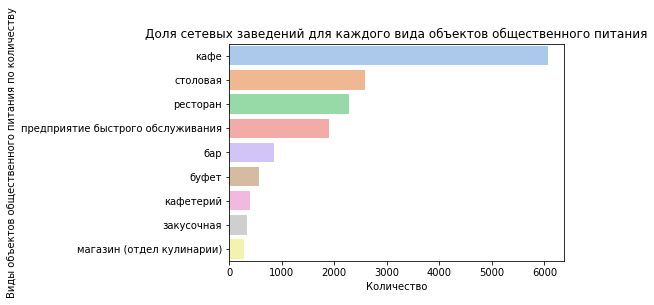

In [14]:
sns.set_palette('pastel') 

graph = sns.barplot(
    x='id', 
    y='object_type', 
    data=type_pivot)

#graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
graph.set_title('Доля сетевых заведений для каждого вида объектов общественного питания')
graph.set_xlabel('Количество')
graph.set_ylabel('Виды объектов общественного питания по количеству')
plt.show()

Кафе значительно больше, чем каких-либо других заведений.

### Исследование соотношения сетевых и несетевых заведений по количеству

Исследуем соотношения сетевых и несетевых заведений по количеству.

In [15]:
chain_pivot = rest_data.pivot_table(
    index='chain', 
    values='id', 
    aggfunc='count'
).sort_values(by='id', ascending=False).reset_index()
chain_pivot

,chain,id
0,False,12317
1,True,2964


Построим круговую диаграмму.

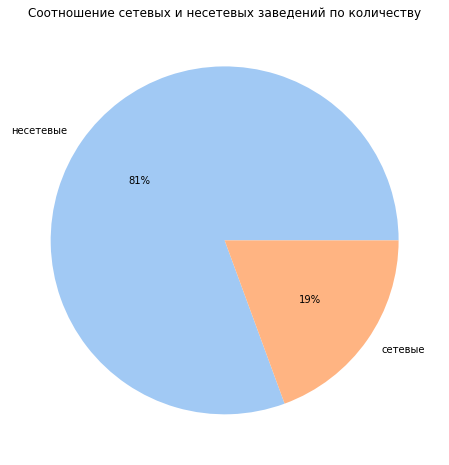

In [16]:
colors = sns.color_palette('pastel')

plt.figure(figsize=(8, 8))
plt.pie(chain_pivot['id'], 
        labels=['несетевые', 'сетевые'],
        colors=colors,
        autopct='%.0f%%')
plt.title('Соотношение сетевых и несетевых заведений по количеству')
plt.show()

<div class="alert alert-success"; style="border-left: 7px solid green">
<h5> ✔️ <font color="green">Комментарий ревьюера (зеленый)</font></h5>

Красивая интерактивная визуализация, молодец!

</div>

Сетевых заведений примерно в 4 раза меньше, чем несетевых.

### Исследование видов объектов общественного питания по сетевому распространению

Изучим, для какого вида объекта общественного питания характерно сетевое распространение.

In [17]:
type_chain_pivot = rest_data.pivot_table(
    index='object_type', 
    values='chain'
).sort_values(by='chain', ascending=False).reset_index()
type_chain_pivot['chain'] = type_chain_pivot['chain'] * 100
type_chain_pivot

,object_type,chain
0,предприятие быстрого обслуживания,41.539273
1,магазин (отдел кулинарии),28.571429
2,ресторан,23.794917
3,кафе,22.994564
4,закусочная,16.091954
5,кафетерий,13.164557
6,бар,4.327485
7,буфет,1.909722
8,столовая,0.116099


Построим столбчатую диаграмму.

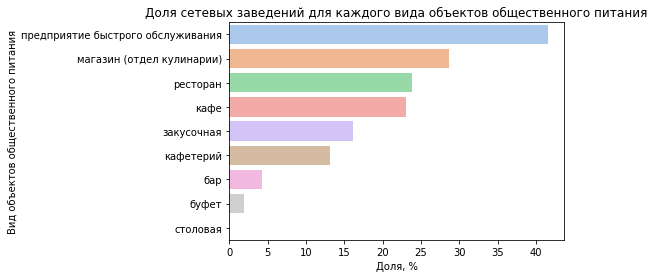

In [18]:
sns.set_palette('pastel') 

graph = sns.barplot(
    x='chain', 
    y='object_type', 
    data=type_chain_pivot)

#graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
graph.set_title('Доля сетевых заведений для каждого вида объектов общественного питания')
graph.set_xlabel('Доля, %')
graph.set_ylabel('Вид объектов общественного питания')
plt.show()

<div class="alert alert-success"; style="border-left: 7px solid green">
<h5> ✔️ <font color="green">Комментарий ревьюера (зеленый)</font></h5>

Красивое и понятное сравнение, спасибо!

</div>

Видим, что для предприятий быстрого обслуживания характерно сетевое распространение: более 40% заведений этого типа сетевые.

Также часто сетевыми являются отделы кулинарии в магазинах (29%), рестораны (24%) и кафе (23%), реже всего сетевыми являются столовые, буфеты и бары (менее 5%).

### Исследование сетевых заведений по посадочным места и количеству заведений в сети

Выясним, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест.

Построим график рассеяния количества заведений в сети и медианного количества посадочных мест в сети

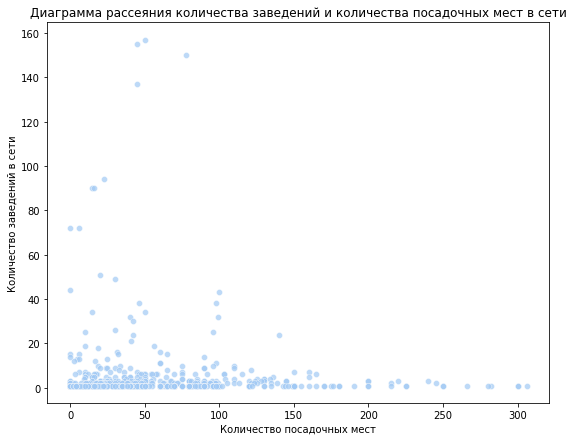

In [19]:
chain_number_pivot = rest_data[rest_data['chain']].pivot_table(
    index='object_name', 
    values=['id', 'number'],
    aggfunc={'id': 'count', 'number': 'median'}
).sort_values(by='id', ascending=False)

plt.figure(figsize=(9, 7))
graph = sns.scatterplot(
    x='number', 
    y='id', 
    data=chain_number_pivot,
    alpha=0.7)
graph.set_title('Диаграмма рассеяния количества заведений и количества посадочных мест в сети')
graph.set_xlabel('Количество посадочных мест')
graph.set_ylabel('Количество заведений в сети')
plt.show()

<div class="alert alert-success"; style="border-left: 7px solid green">
<h5> ✔️ <font color="green">Комментарий ревьюера (зеленый)</font></h5>

График построен верно.

</div>

На графике оказалось очень много сетей с одним заведением: такие данные надо отправить на пересборку. 

Пока построим этот же график с количеством заведений в сети, больших одного.

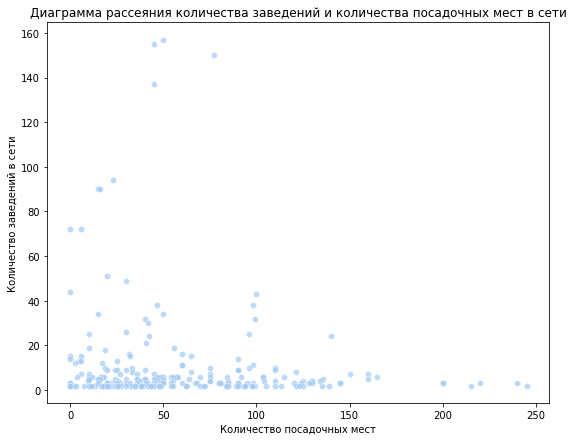

In [20]:
plt.figure(figsize=(9, 7))
graph = sns.scatterplot(
    x='number', 
    y='id', 
    data=chain_number_pivot.query('id > 1'),
    alpha=0.7)
graph.set_title('Диаграмма рассеяния количества заведений и количества посадочных мест в сети')
graph.set_xlabel('Количество посадочных мест')
graph.set_ylabel('Количество заведений в сети')
plt.show()

Большинство точек сконцентрировано в снизу: большинство сетей имеют небольшое количество заведений и среднее количество посадочных мест.

### Исследование среднего количества посадочных мест по виду объекта общественного питания

Изучим среднее количество мест по виду объекта общественного питания. Будем использовать медианное значение вместо среднего.

In [21]:
type_number_pivot = rest_data.pivot_table(
    index=['object_type', 'chain'], 
    values='number', 
    aggfunc='median'
).sort_values(by='number', ascending=False).reset_index()
type_number_pivot

,object_type,chain,number
0,столовая,True,120.0
1,столовая,False,103.0
2,ресторан,True,89.0
3,ресторан,False,75.0
4,бар,True,45.0
5,кафе,True,40.0
6,бар,False,34.0
7,буфет,False,32.0
8,кафе,False,30.0
9,предприятие быстрого обслуживания,True,25.0


Построим столбчатую диаграмму с разделением на сетевое/несетевое.

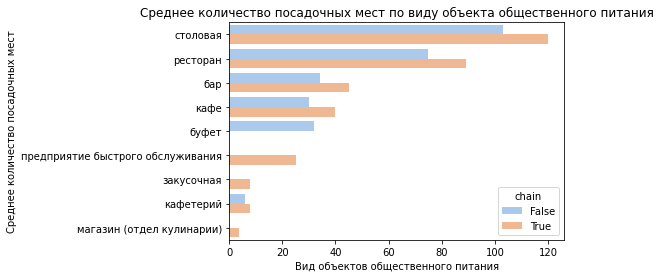

In [22]:
sns.set_palette('pastel') 

graph = sns.barplot(
    x='number', 
    y='object_type',
    hue='chain',
    data=type_number_pivot)

#graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
graph.set_title('Среднее количество посадочных мест по виду объекта общественного питания')
graph.set_xlabel('Вид объектов общественного питания')
graph.set_ylabel('Среднее количество посадочных мест')
plt.show()

Самое большое среднее количество посадочных мест в столовых (120 для сетевых, 103 – для несетевых), потом идут – рестораны (89, 75), а самое маленькое – в закусочных и в отделах кулинарии магазинов (медианное значение – 0).

### Создание нового столбца с названием улицы

Выделим улицу из адреса в отдельный столбец. В некоторых адресах нет улицы (эти адреса находятся в поселка и т. п.): для таких адресов улица определена не будет. 

In [23]:
def street_definition(data):
    street_types = ['улица', 'бульвар', 'проспект', 'переулок', 'шоссе', 
'проезд', 'набережная', 'площадь', 'аллея', 'линия', 'квартал', 'мост', 'тупик', 'просека']
    street =  data.split(',')[1]
    for value in street.split(' '):
        if value in street_types:
            return street

rest_data['street'] = rest_data['address'].apply(street_definition)

rest_data.head()

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,False,кафе,"город москва, улица егора абакумова, дом 9",48,улица егора абакумова
1,77874,родник,False,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,улица талалихина
2,24309,кафе «академия»,False,кафе,"город москва, абельмановская улица, дом 6",95,абельмановская улица
3,21894,пиццетория,True,кафе,"город москва, абрамцевская улица, дом 1",40,абрамцевская улица
4,119365,кафе «вишневая метель»,False,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,абрамцевская улица


Посчитает, какая доля заведений не получила улицу.

In [24]:
rest_data['street'].isna().mean()

0.06380472482167397

Всего ~6%: удалим эти значения, они не понадобятся в дальшнейшем анализе.

In [25]:
rest_data = rest_data.dropna()

Проверим.

In [26]:
rest_data['street'].isna().mean()

0.0

### Поиск топ-10 улиц по количеству объектов общественного питания

Найдем топ-10 по количеству объектов общественного питания.

In [27]:
street_pivot = rest_data.pivot_table(
    index='street', 
    values='id', 
    aggfunc='count'
).sort_values(by='id', ascending=False).reset_index().head(10)
street_pivot

,street,id
0,проспект мира,203
1,профсоюзная улица,181
2,ленинградский проспект,170
3,пресненская набережная,167
4,варшавское шоссе,161
5,ленинский проспект,147
6,проспект вернадского,128
7,кутузовский проспект,114
8,каширское шоссе,111
9,кировоградская улица,108


Построим столбчатую диаграмму.

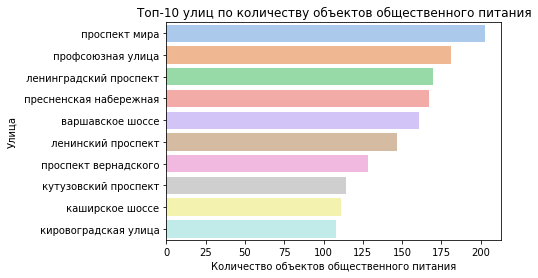

In [28]:
sns.set_palette('pastel') 

graph = sns.barplot(
    x='id', 
    y='street', 
    data=street_pivot)

#graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
graph.set_title('Топ-10 улиц по количеству объектов общественного питания')
graph.set_xlabel('Количество объектов общественного питания')
graph.set_ylabel('Улица')
plt.show()

### Определение района по улице

Загрузим внешний файл МосГаза с названиями улиц и районов Москвы.

In [29]:
from io import BytesIO
import requests
spreadsheet_id = '1NR2D3QC66qC9Umy4h0HREgdMH1T0B198Wkevg2L9J9A'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id) 
r = requests.get(file_name)
street_data = pd.read_csv(BytesIO(r.content))
street_data.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


Приведем его к виду для присоединения.

In [30]:
street_data['streetname'] = street_data['streetname'].str.lower()
street_data['streetname'] = street_data['streetname'].str.strip()
street_data = street_data[['streetname', 'area', 'okrug']].sort_values(by='streetname')
street_data.columns = ['street', 'district', 'county']
street_data['street'] = street_data['street'].astype(str)
street_data.head()

,street,district,county
3145,1-й автозаводский проезд,Даниловский район,ЮАО
1829,1-й амбулаторный проезд,Район Аэропорт,САО
2400,1-й архивный переулок,Район Хамовники,ЦАО
3940,1-й бабьегородский переулок,Район Якиманка,ЦАО
1834,1-й балтийский переулок,Район Аэропорт,САО


Объединим датафреймы.

In [38]:
street_pivot['street'] = street_pivot['street'].str.strip()

street_pivot =  pd.merge(
    left=street_pivot['street'],
    right=street_data, 
    on='street', 
    how='left')
street_pivot = street_pivot.fillna('')
street_pivot

,street,district,county
0,яхромская улица,Дмитровский район,САО
1,рижский проезд,Алексеевский район,СВАО
2,улица инессы арманд,Район Ясенево,ЮЗАО
3,радужная улица,Бабушкинский район,СВАО
4,варсонофьевский переулок,Мещанский район,ЦАО
...,...,...,...
868,3-й угрешский проезд,Район Печатники,ЮВАО
869,5-й котельнический переулок,Таганский район,ЦАО
870,5-й проезд подбельского,Район Богородское,ВАО
871,5-й монетчиковский переулок,Район Замоскворечье,ЦАО


In [37]:
street_pivot.groupby('street')['county'].apply(', '.join)

street
1-й балтийский переулок                     САО
1-й басманный переулок       ЦАО, ЦАО, ЦАО, ЦАО
1-й ботанический проезд                    СВАО
1-й вешняковский проезд                    ЮВАО
1-й голутвинский переулок                   ЦАО
                                    ...        
ялтинская улица                             ЮАО
янтарный проезд                            СВАО
ясногорская улица                          ЮЗАО
яузский бульвар                             ЦАО
яхромская улица                             САО
Name: county, Length: 524, dtype: object

Видим, что все улицы из топ-10 проходят через несколько районов.

### Нахождение числа улиц с одним объектом общественного питания

Найдем число улиц с одним объектом общественного питания.

In [33]:
street_pivot = rest_data.pivot_table(
    index='street', 
    values='id', 
    aggfunc='count'
).sort_values(by='id').reset_index().query('id == 1')

print('Число улиц с одним объектом общественного питания:', street_pivot['id'].count())

Число улиц с одним объектом общественного питания: 524


Найдем в каких районах находятся такие улицы

In [34]:
street_pivot['street'] = street_pivot['street'].str.strip()

street_pivot = street_pivot.merge(
    street_data, 
    on='street', 
    how='left')

one_catering_pivot = street_pivot.pivot_table(
    index=['district', 'county'], 
    values='street', 
    aggfunc='count').reset_index().sort_values(by='street', ascending=False)
one_catering_pivot.head()

,district,county,street
93,Таганский район,ЦАО,27
79,Район Хамовники,ЦАО,26
3,Басманный район,ЦАО,25
94,Тверской район,ЦАО,20
20,Пресненский район,ЦАО,19


Построим столбчатую диаграмму.

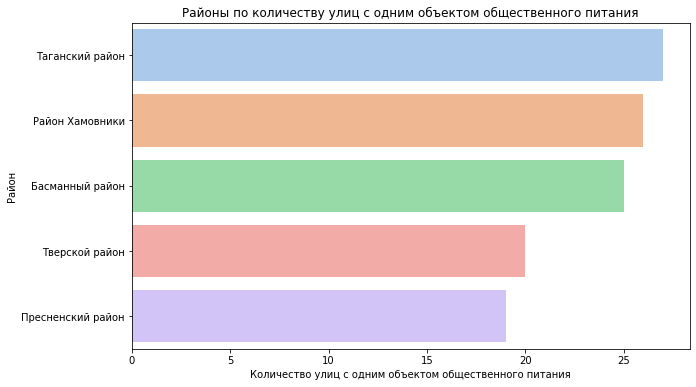

In [35]:
sns.set_palette('pastel') 


plt.figure(figsize=(10, 6))
graph = sns.barplot(
    x='street', 
    y='district', 
    data=one_catering_pivot.head())

#graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
graph.set_title('Районы по количеству улиц с одним объектом общественного питания')
graph.set_xlabel('Количество улиц с одним объектом общественного питания')
graph.set_ylabel('Район')
plt.show()

Видим, что в самых крупных районах ЦАО (Таганский, Хамовники и Басманный) находятся самое большое количество улиц с одним объектом общественного питания.

## Вывод

Был изучен рынок заведений общественного питания Москвы. Был открыт и предобработан датафрейм с данными:
- *пропуски* найдены не были;
- данные были приведены к *нужному типу*: тип данных столбца chain к типу 'bool';
- были удалены 85 *дубликатов*;
- были добавлены два *новых столбца*: `district` с названием района улицы, `county` с название округа по улице.

В ходе исследования были сделаны следующие выводы:
- **вид объектов общественного питания по количеству**: самым популярным видом является *кафе* (40% от всех), далее идут – столовые (17%), рестораны (15%) и предприятия быстрого обслуживания (12%), самыми редкими являются закусочные и отделы кулинарии в магазинах (по 2%);
- **сетевые заведения**: лишь пятая часть (19%) заведений входят в сети, чаще всего сетевыми являются предприятие быстрого обслуживания (42%), отделы кулинарии в магазинах (29%), рестораны (24%) и кафе (23%), реже всего сетевыми являются столовые, буфеты и бары (менее 5%);
- **посадочные места**: самое большое количество посадочных мест в столовых (103) и ресторанах (80), далее следуют бары (35), буфеты (32) и кафе (30), самое маленькое количество посадочных мест в закусочных и отделах кулинарии магазинов (чаще всего посадочных мест нет); также выяснили, что преобладают сети с небольшим количеством заведений (до 20) и средним количеством посадочных мест (до 70);
- **расположение объектов общественного питания**: были найдены топ-10 улицы по количеству объектов общественного питания: все они проходят через несколько районов (в основном через районы ; количество улиц с одним заведением общественного питания – 596: в основном они располагаются в районах ЦАО (Таганский, Хамовники, Басманный, Тверской, Пресненский).

Удалось подтвердить, что небольшое кафе – это удачный вариант для открытия объекта общественного питания. Рекомендации: количество посадочных мест – около 30, расположение – в одном из районов ЗАО, ЮЗАО или ЮАО (в основном там располагаются топ-10 улиц по количеству объектов общественного питания.
Развитие сети возможно: 25% кафе являются сетевыми.

## [Презентация](https://disk.yandex.ru/i/2pSiJafF9iak7g)